(ordinal_regression)=
# Regression Models with Ordered Categorical Outcomes

:::{post} April, 2023
:tags: ordinal regression, generalized linear model, 
:category: beginner, reference
:author: Nathaniel Forde
:::

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import statsmodels.api as sm

from scipy.stats import bernoulli
from statsmodels.miscmodels.ordinal_model import OrderedModel

In [2]:
%config InlineBackend.figure_format = 'retina'  # high resolution figures
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(42)

## Ordered Categories: Known Distribution

We'll start by generating some fake data. Imagine an employee/manager relationship where part of the annual process involves conducting a 360 degree review. The manager gets a rating (1 - 10) by their team and HR collects these ratings. The HR manager wants to know which factors influence the manager's rating and what can move a manager who receives a 4 into a 5 or a 7 into an 8. They have a theory that the rating is largely a function of salary. 

Ordinal Regression is a statistical technique designed to model these kinds of relationships. 

In [3]:
def make_data():
    salary = np.random.normal(40, 10, 500)
    work_sat = np.random.beta(1, 0.4, 500)
    work_from_home = bernoulli.rvs(0.7, size=500)
    latent_rating = (
        0.08423 * salary + 0.2 * work_sat + 0.4 * work_from_home + np.random.normal(0, 1, 500)
    )
    explicit_rating = np.round(latent_rating, 0)
    df = pd.DataFrame(
        {
            "salary": salary,
            "work_sat": work_sat,
            "work_from_home": work_from_home,
            "latent_rating": latent_rating,
            "explicit_rating": explicit_rating,
        }
    )
    return df


try:
    df = pd.read_csv("../data/fake_employee_manger_rating.csv")
except FileNotFoundError:
    df = make_data()

K = len(df["explicit_rating"].unique())
df.head()

,Unnamed: 0,salary,work_sat,work_from_home,latent_rating,explicit_rating
0,0,46.007926,0.888214,1,5.288540,5.0
1,1,28.558764,1.000000,1,2.632786,3.0
2,2,63.675595,0.979369,1,4.747722,5.0
3,3,31.426154,0.999981,1,5.051418,5.0
4,4,36.950311,0.456972,1,4.857587,5.0


We've specified our data in such a way that there is an underlying latent sentiment which is continuous in scale that gets crudely discretised to represent the ordinal rating scale. We've specified the data in such a way that salary drives a fairly linear increase in the manager's rating. 

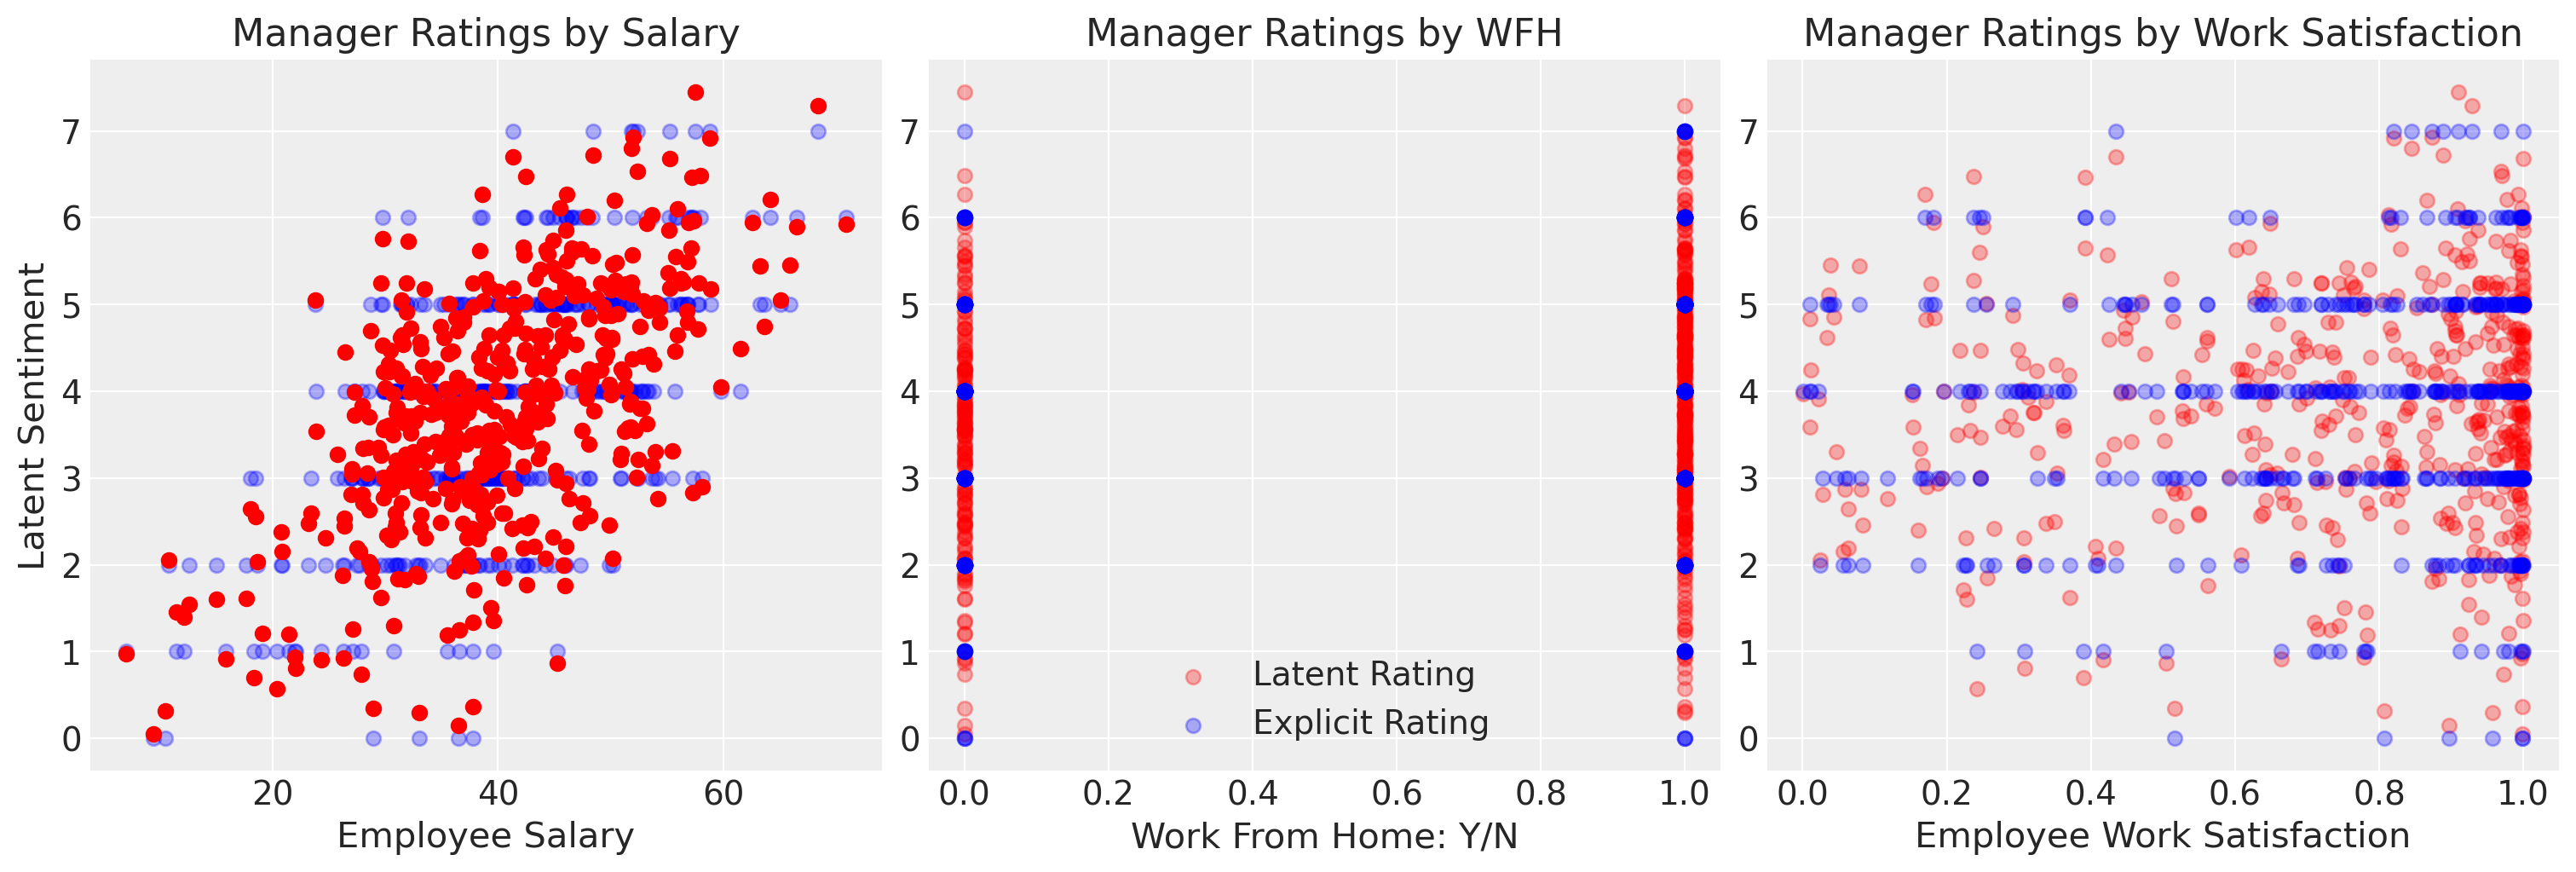

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs = axs.flatten()
ax = axs[0]
ax.scatter(df["salary"], df["explicit_rating"], label="Explicit Rating", color="blue", alpha=0.3)
axs[1].scatter(
    df["work_from_home"], df["latent_rating"], label="Latent Rating", color="red", alpha=0.3
)
axs[1].scatter(
    df["work_from_home"], df["explicit_rating"], label="Explicit Rating", c="blue", alpha=0.3
)
axs[2].scatter(df["work_sat"], df["latent_rating"], label="Latent Rating", color="red", alpha=0.3)
axs[2].scatter(
    df["work_sat"], df["explicit_rating"], label="Explicit Rating", color="blue", alpha=0.3
)
ax.scatter(df["salary"], df["latent_rating"], label="Latent Sentiment", color="red")
ax.set_title("Manager Ratings by Salary")
axs[1].set_title("Manager Ratings by WFH")
axs[2].set_title("Manager Ratings by Work Satisfaction")
ax.set_ylabel("Latent Sentiment")
ax.set_xlabel("Employee Salary")
axs[1].set_xlabel("Work From Home: Y/N")
axs[2].set_xlabel("Employee Work Satisfaction")
axs[1].legend();

We can see here however that if we fit this model with a simple OLS fit it implies values beyond the categorical scale, which might motivate spurious salary increases by an overzealous HR manager. The OLS approximation is not bad, but is limited in that it cannot account for the proper nature of the outcome variable. 

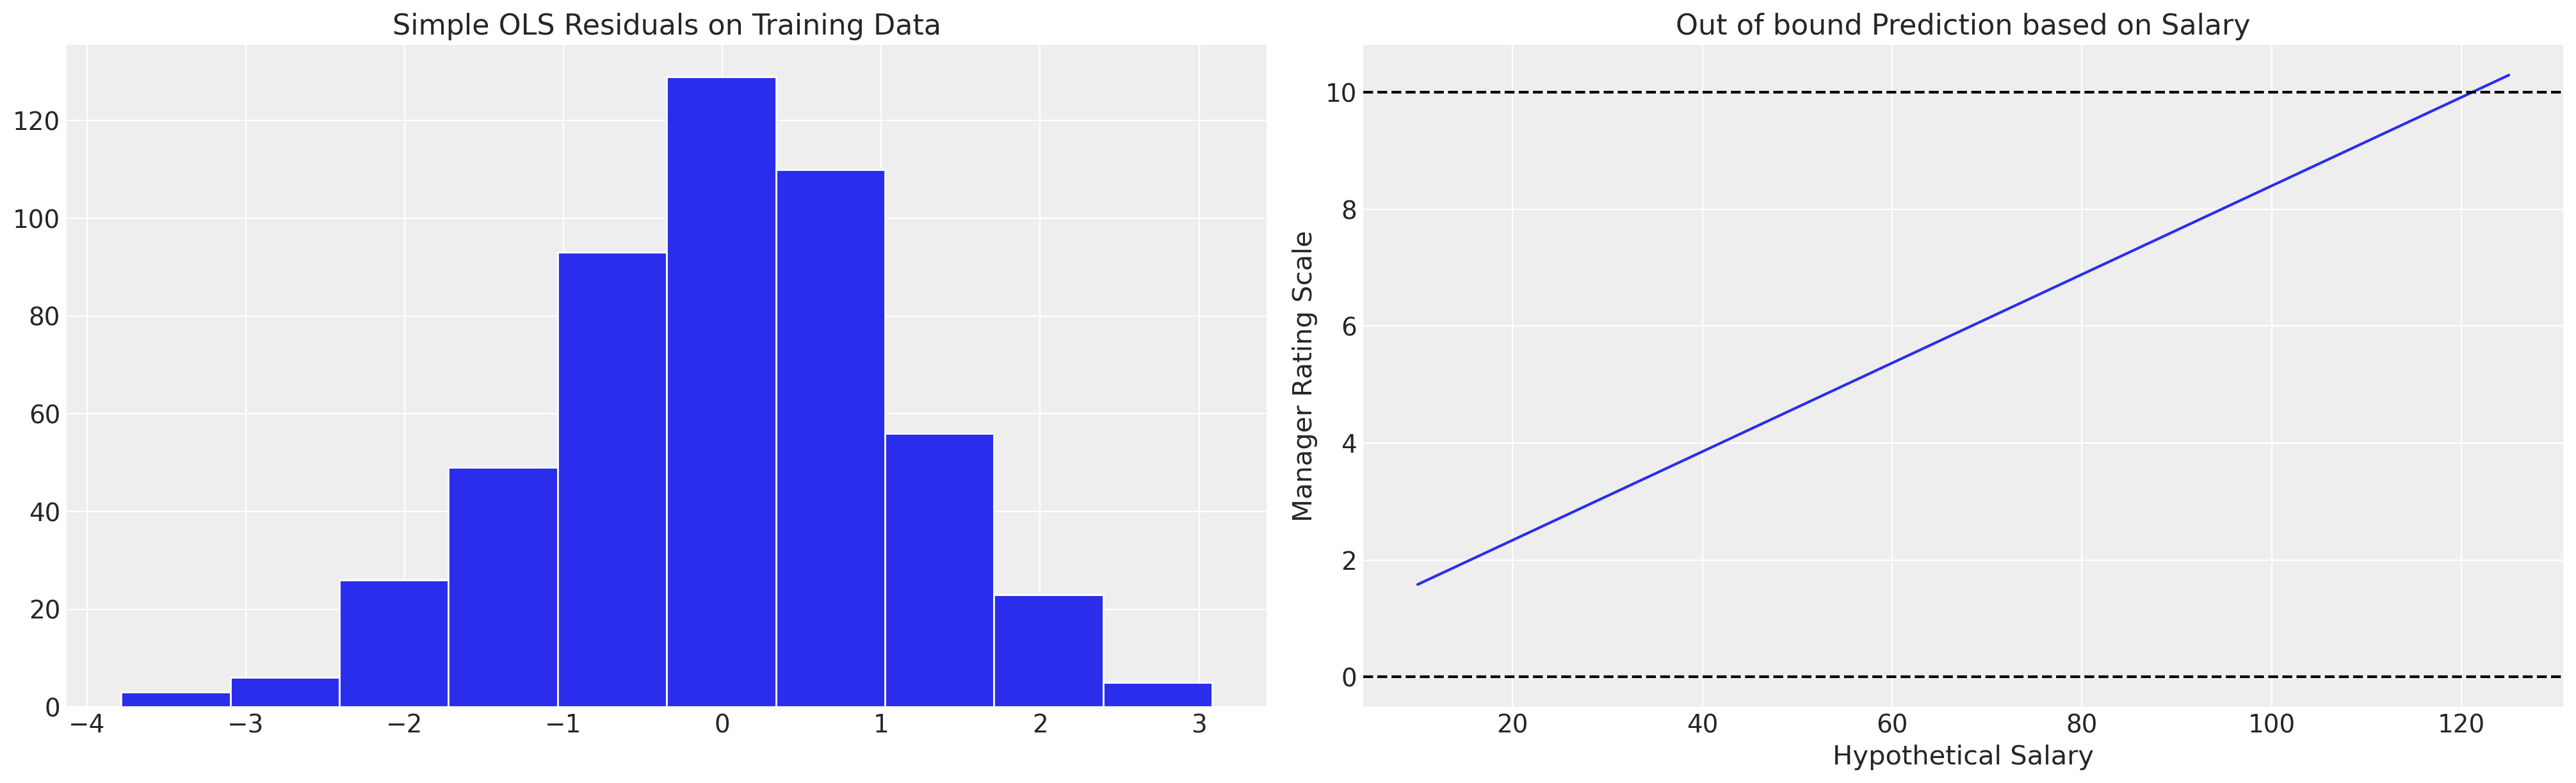

In [5]:
exog = sm.add_constant(df[["salary", "work_from_home", "work_sat"]])
mod = sm.OLS(df["explicit_rating"], exog)
results = mod.fit()
results.summary()

results.predict([1, 200, 1, 0.6])
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs = axs.flatten()
ax = axs[1]
salaries = np.linspace(10, 125, 20)
predictions = [results.predict([1, i, 1, 0.6])[0] for i in salaries]
ax.plot(salaries, predictions, label="Implied Linear function of Salaries on Outcome")
ax.set_title("Out of bound Prediction based on Salary")
ax.axhline(10, linestyle="--", color="black")
ax.set_xlabel("Hypothetical Salary")
ax.set_ylabel("Manager Rating Scale")
ax.axhline(0, linestyle="--", color="black")
axs[0].hist(results.resid, ec="white")
axs[0].set_title("Simple OLS Residuals on Training Data");

## Ordinal Regression Models: The Idea

In this notebook we'll show how to fit regression models to outcomes with ordered categories. These types of models can be considered as an application logistic regression models with multiple thresholds on a latent continuous scale. 


## Fit a variety of Model Specifications

In [6]:
def constrainedUniform(N, min=0, max=1):
    return pm.Deterministic(
        "cutpoints",
        pt.concatenate(
            [
                np.ones(1) * min,
                pt.extra_ops.cumsum(pm.Dirichlet("cuts_unknown", a=np.ones(N - 2)))
                * (min + (max - min)),
            ]
        ),
    )


def make_model(priors, model_spec=1, constrained_uniform=False):
    with pm.Model() as model:

        if constrained_uniform:
            cutpoints = constrainedUniform(K, 0, K)
        else:
            sigma = pm.Exponential("sigma", priors["sigma"])
            cutpoints = pm.Normal(
                "cutpoints",
                mu=priors["mu"],
                sigma=sigma,
                transform=pm.distributions.transforms.univariate_ordered,
            )

        if model_spec == 1:
            beta = pm.Normal("beta", priors["beta"][0], priors["beta"][1], size=1)
            mu = pm.Deterministic("mu", beta[0] * df.salary)
        elif model_spec == 2:
            beta = pm.Normal("beta", priors["beta"][0], priors["beta"][1], size=2)
            mu = pm.Deterministic("mu", beta[0] * df.salary + beta[1] * df.work_sat)
        else:
            beta = pm.Normal("beta", priors["beta"][0], priors["beta"][1], size=3)
            mu = pm.Deterministic(
                "mu", beta[0] * df.salary + beta[1] * df.work_sat + beta[2] * df.work_from_home
            )
        y_ = pm.OrderedLogistic("y", cutpoints=cutpoints, eta=mu, observed=df.explicit_rating)
        idata = pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True})
        idata.extend(pm.sample_posterior_predictive(idata))
    return idata, model


priors = {"sigma": 1, "beta": [0, 1], "mu": np.linspace(0, K, K - 1)}
idata1, model1 = make_model(priors, model_spec=1)
idata2, model2 = make_model(priors, model_spec=2)
idata3, model3 = make_model(priors, model_spec=3)
idata4, model4 = make_model(priors, model_spec=3, constrained_uniform=True)

/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.11/site-packages/pymc/sampling/mcmc.py:242: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.011609
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:04.139100
Transforming variables...
Transformation time =  0:00:00.410297
Computing Log Likelihood...


Sampling: [y]


Log Likelihood time =  0:00:00.557751


/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.11/site-packages/pymc/sampling/mcmc.py:242: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.587907
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:04.475725
Transforming variables...
Transformation time =  0:00:00.189797
Computing Log Likelihood...


Sampling: [y]


Log Likelihood time =  0:00:00.311269


/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.11/site-packages/pymc/sampling/mcmc.py:242: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.698703
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:04.735718
Transforming variables...
Transformation time =  0:00:00.149607
Computing Log Likelihood...


Sampling: [y]


Log Likelihood time =  0:00:00.298859


/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.11/site-packages/pymc/sampling/mcmc.py:242: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:02.247736
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:03.458061
Transforming variables...
Transformation time =  0:00:00.285049
Computing Log Likelihood...


Sampling: [y]


Log Likelihood time =  0:00:00.300607


In [25]:
az.summary(idata3, var_names=["sigma", "cutpoints", "beta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,1.134,0.468,0.418,2.004,0.011,0.008,1661.0,2147.0,1.0
cutpoints[0],-0.732,0.472,-1.612,0.136,0.010,0.008,2057.0,2048.0,1.0
cutpoints[1],1.382,0.373,0.741,2.122,0.008,0.006,2565.0,2248.0,1.0
cutpoints[2],3.037,0.382,2.375,3.784,0.009,0.006,1928.0,2155.0,1.0
cutpoints[3],4.491,0.402,3.765,5.231,0.010,0.007,1853.0,2159.0,1.0
cutpoints[4],6.095,0.439,5.347,6.948,0.011,0.008,1749.0,1819.0,1.0
cutpoints[5],7.910,0.494,7.049,8.849,0.012,0.009,1702.0,1881.0,1.0
cutpoints[6],9.930,0.637,8.776,11.152,0.016,0.011,1567.0,2339.0,1.0
beta[0],0.116,0.009,0.100,0.133,0.000,0.000,1806.0,2113.0,1.0
beta[1],0.161,0.272,-0.345,0.681,0.005,0.004,3033.0,2790.0,1.0


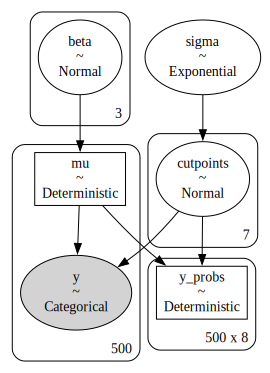

In [8]:
pm.model_to_graphviz(model3)

### Extracting the Probabilities 

In [9]:
implied_probs = az.extract(idata3, var_names=["y_probs"])
implied_probs.shape

(500, 8, 4000)

In [10]:
implied_probs[0].mean(axis=1)

<xarray.DataArray 'y_probs' (y_probs_dim_1: 8)>
array([0.00147233, 0.00951779, 0.0427484 , 0.14050839, 0.34915414,
       0.3350405 , 0.10263828, 0.01892018])
Coordinates:
    y_probs_dim_0  int64 0
  * y_probs_dim_1  (y_probs_dim_1) int64 0 1 2 3 4 5 6 7

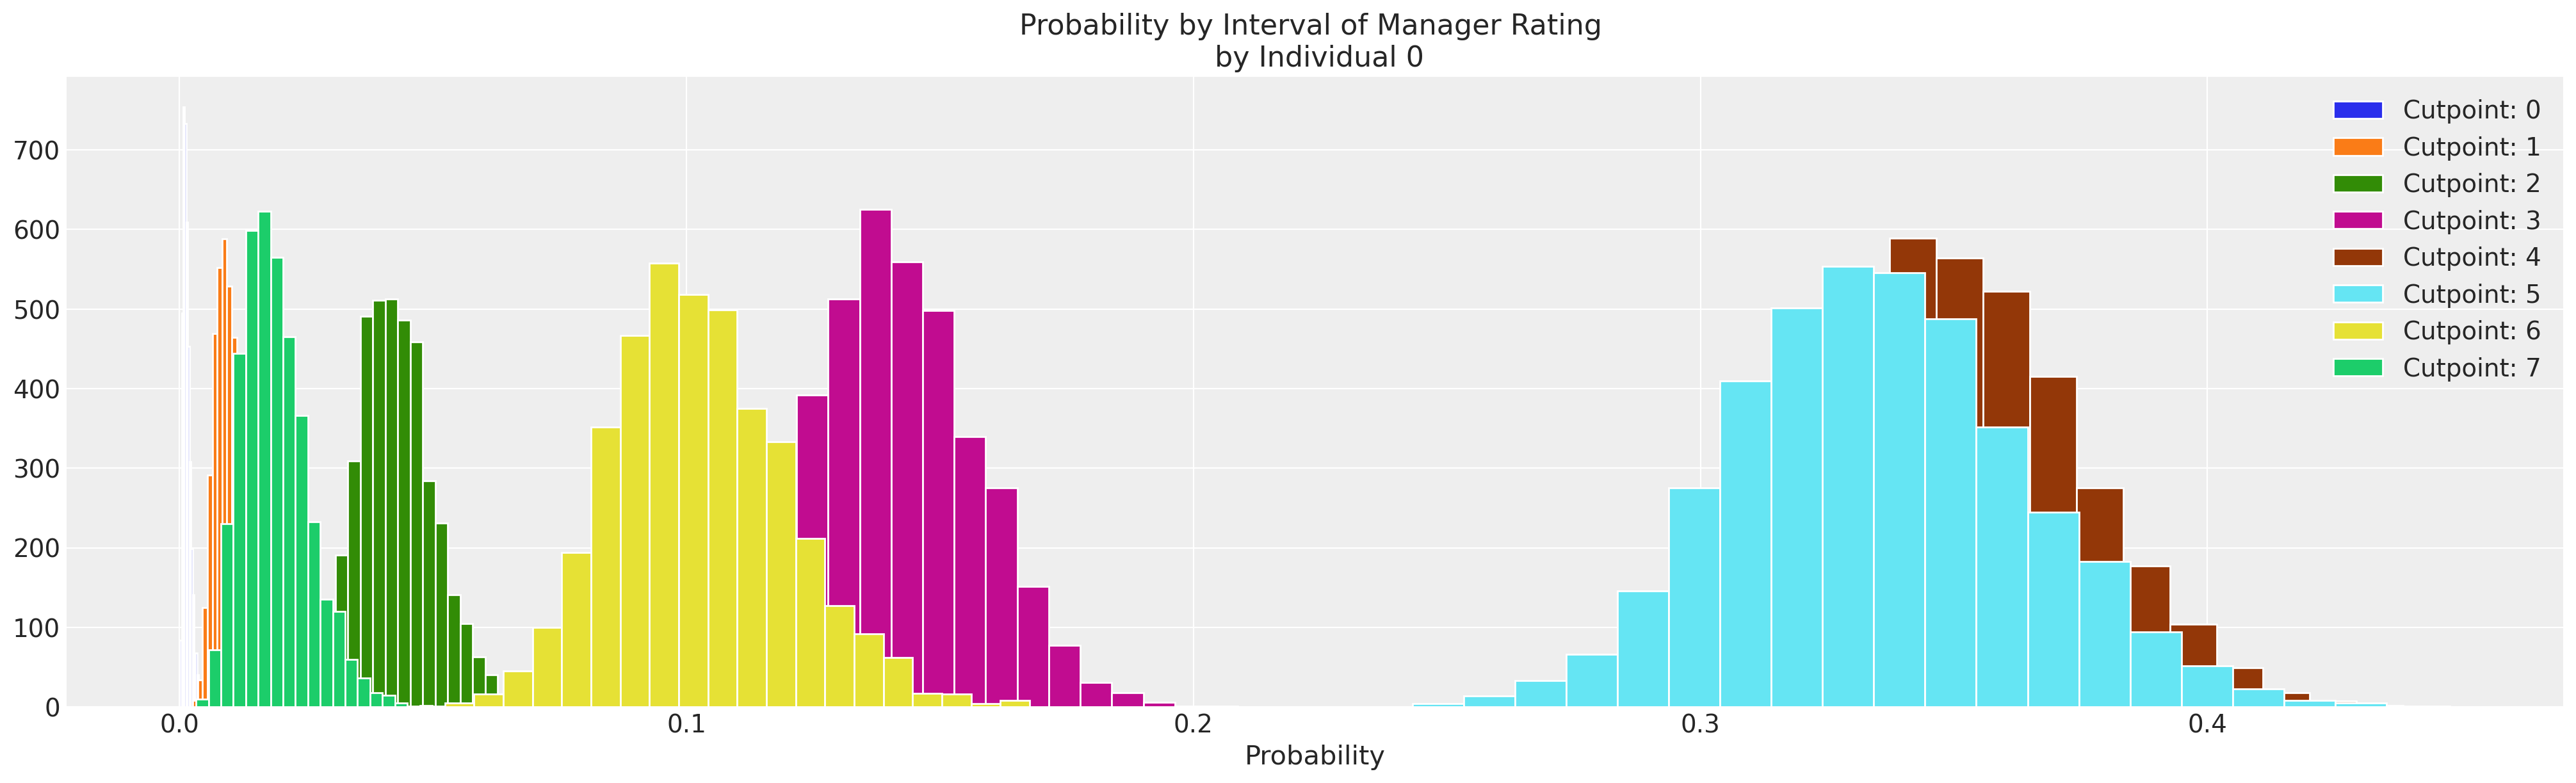

In [11]:
fig, ax = plt.subplots(figsize=(20, 6))
for i in range(K):
    ax.hist(implied_probs[0, i, :], label=f"Cutpoint: {i}", ec="white", bins=20)
ax.set_xlabel("Probability")
ax.set_title("Probability by Interval of Manager Rating \n by Individual 0")
ax.legend()

In [12]:
implied_class = az.extract(idata3, var_names=["y"], group="posterior_predictive")
implied_class.shape

(500, 4000)

In [13]:
from scipy.stats import mode

mode(implied_class[0])

/var/folders/__/ng_3_9pn1f11ftyml_qr69vh0000gn/T/ipykernel_85490/3701407745.py:2: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode(implied_class[0])


ModeResult(mode=array([4]), count=array([1406]))

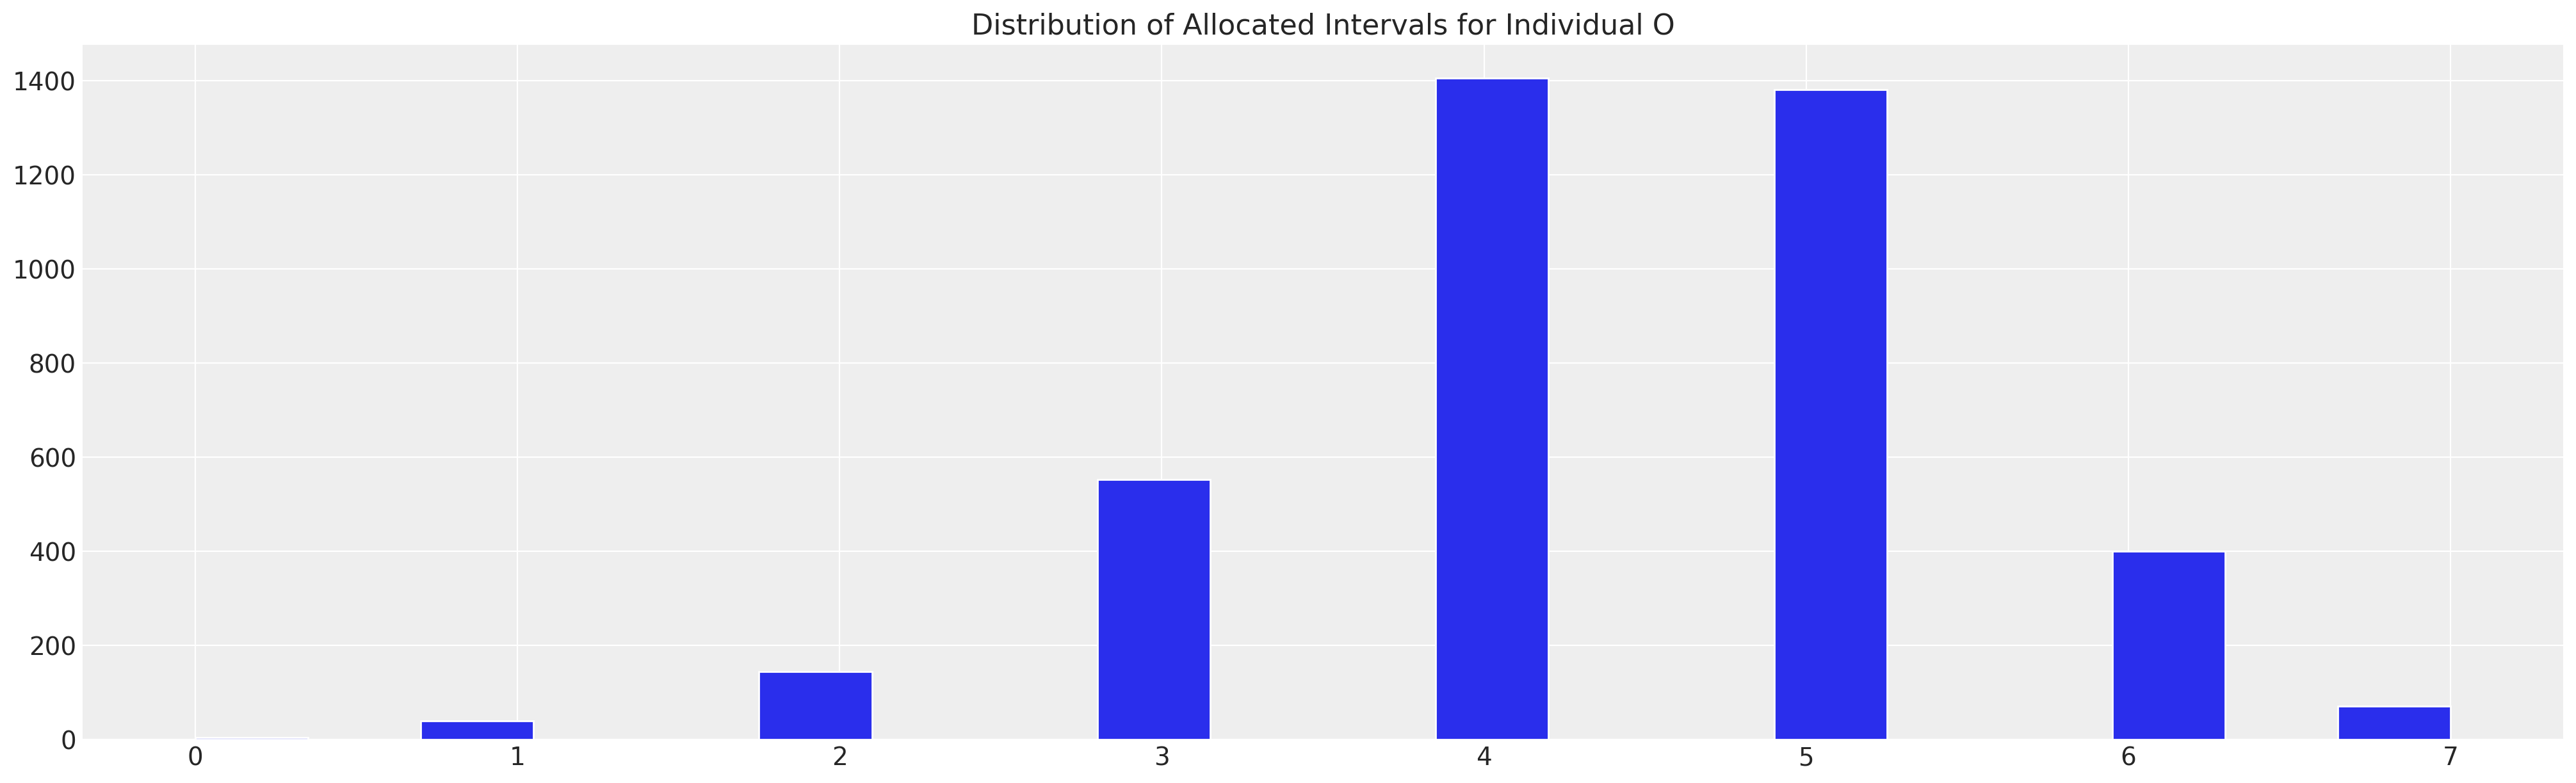

In [14]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.hist(implied_class[0], ec="white", bins=20)
ax.set_title("Distribution of Allocated Intervals for Individual O");

## Compare Models: Parameter Fits and LOO

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_full,0,-770.131562,9.613129,0.000000,0.664898,16.412258,0.000000,False,log
model_salary,1,-772.048780,7.371128,1.917218,0.141679,16.437832,2.485038,False,log
model_salary_worksat,2,-772.548573,8.443001,2.417011,0.000000,16.458799,2.388040,False,log
constrained_uniform,3,-776.659421,6.831796,6.527859,0.193423,13.249242,4.857646,False,log


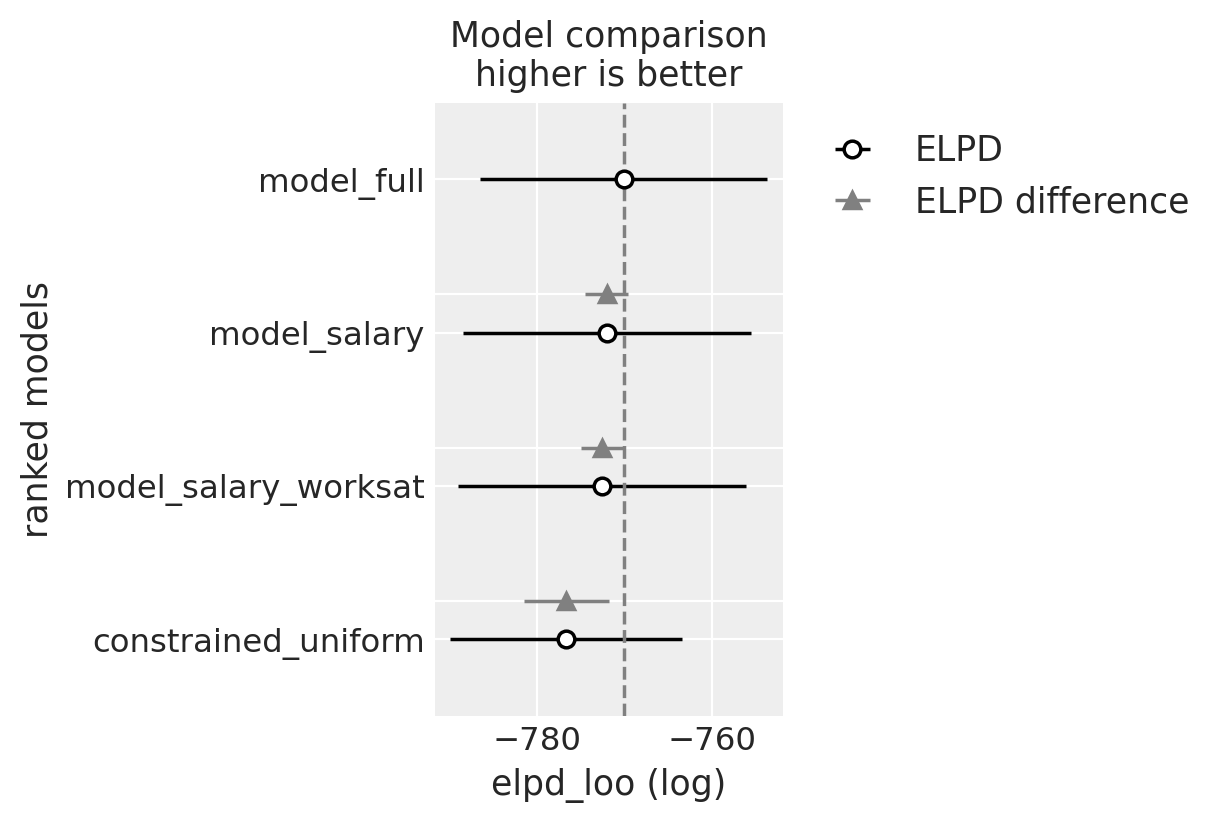

In [15]:
compare = az.compare(
    {
        "model_salary": idata1,
        "model_salary_worksat": idata2,
        "model_full": idata3,
        "constrained_uniform": idata4,
    }
)

az.plot_compare(compare)
compare

/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


Text(0.5, 1.0, 'Model Parameter Estimates')

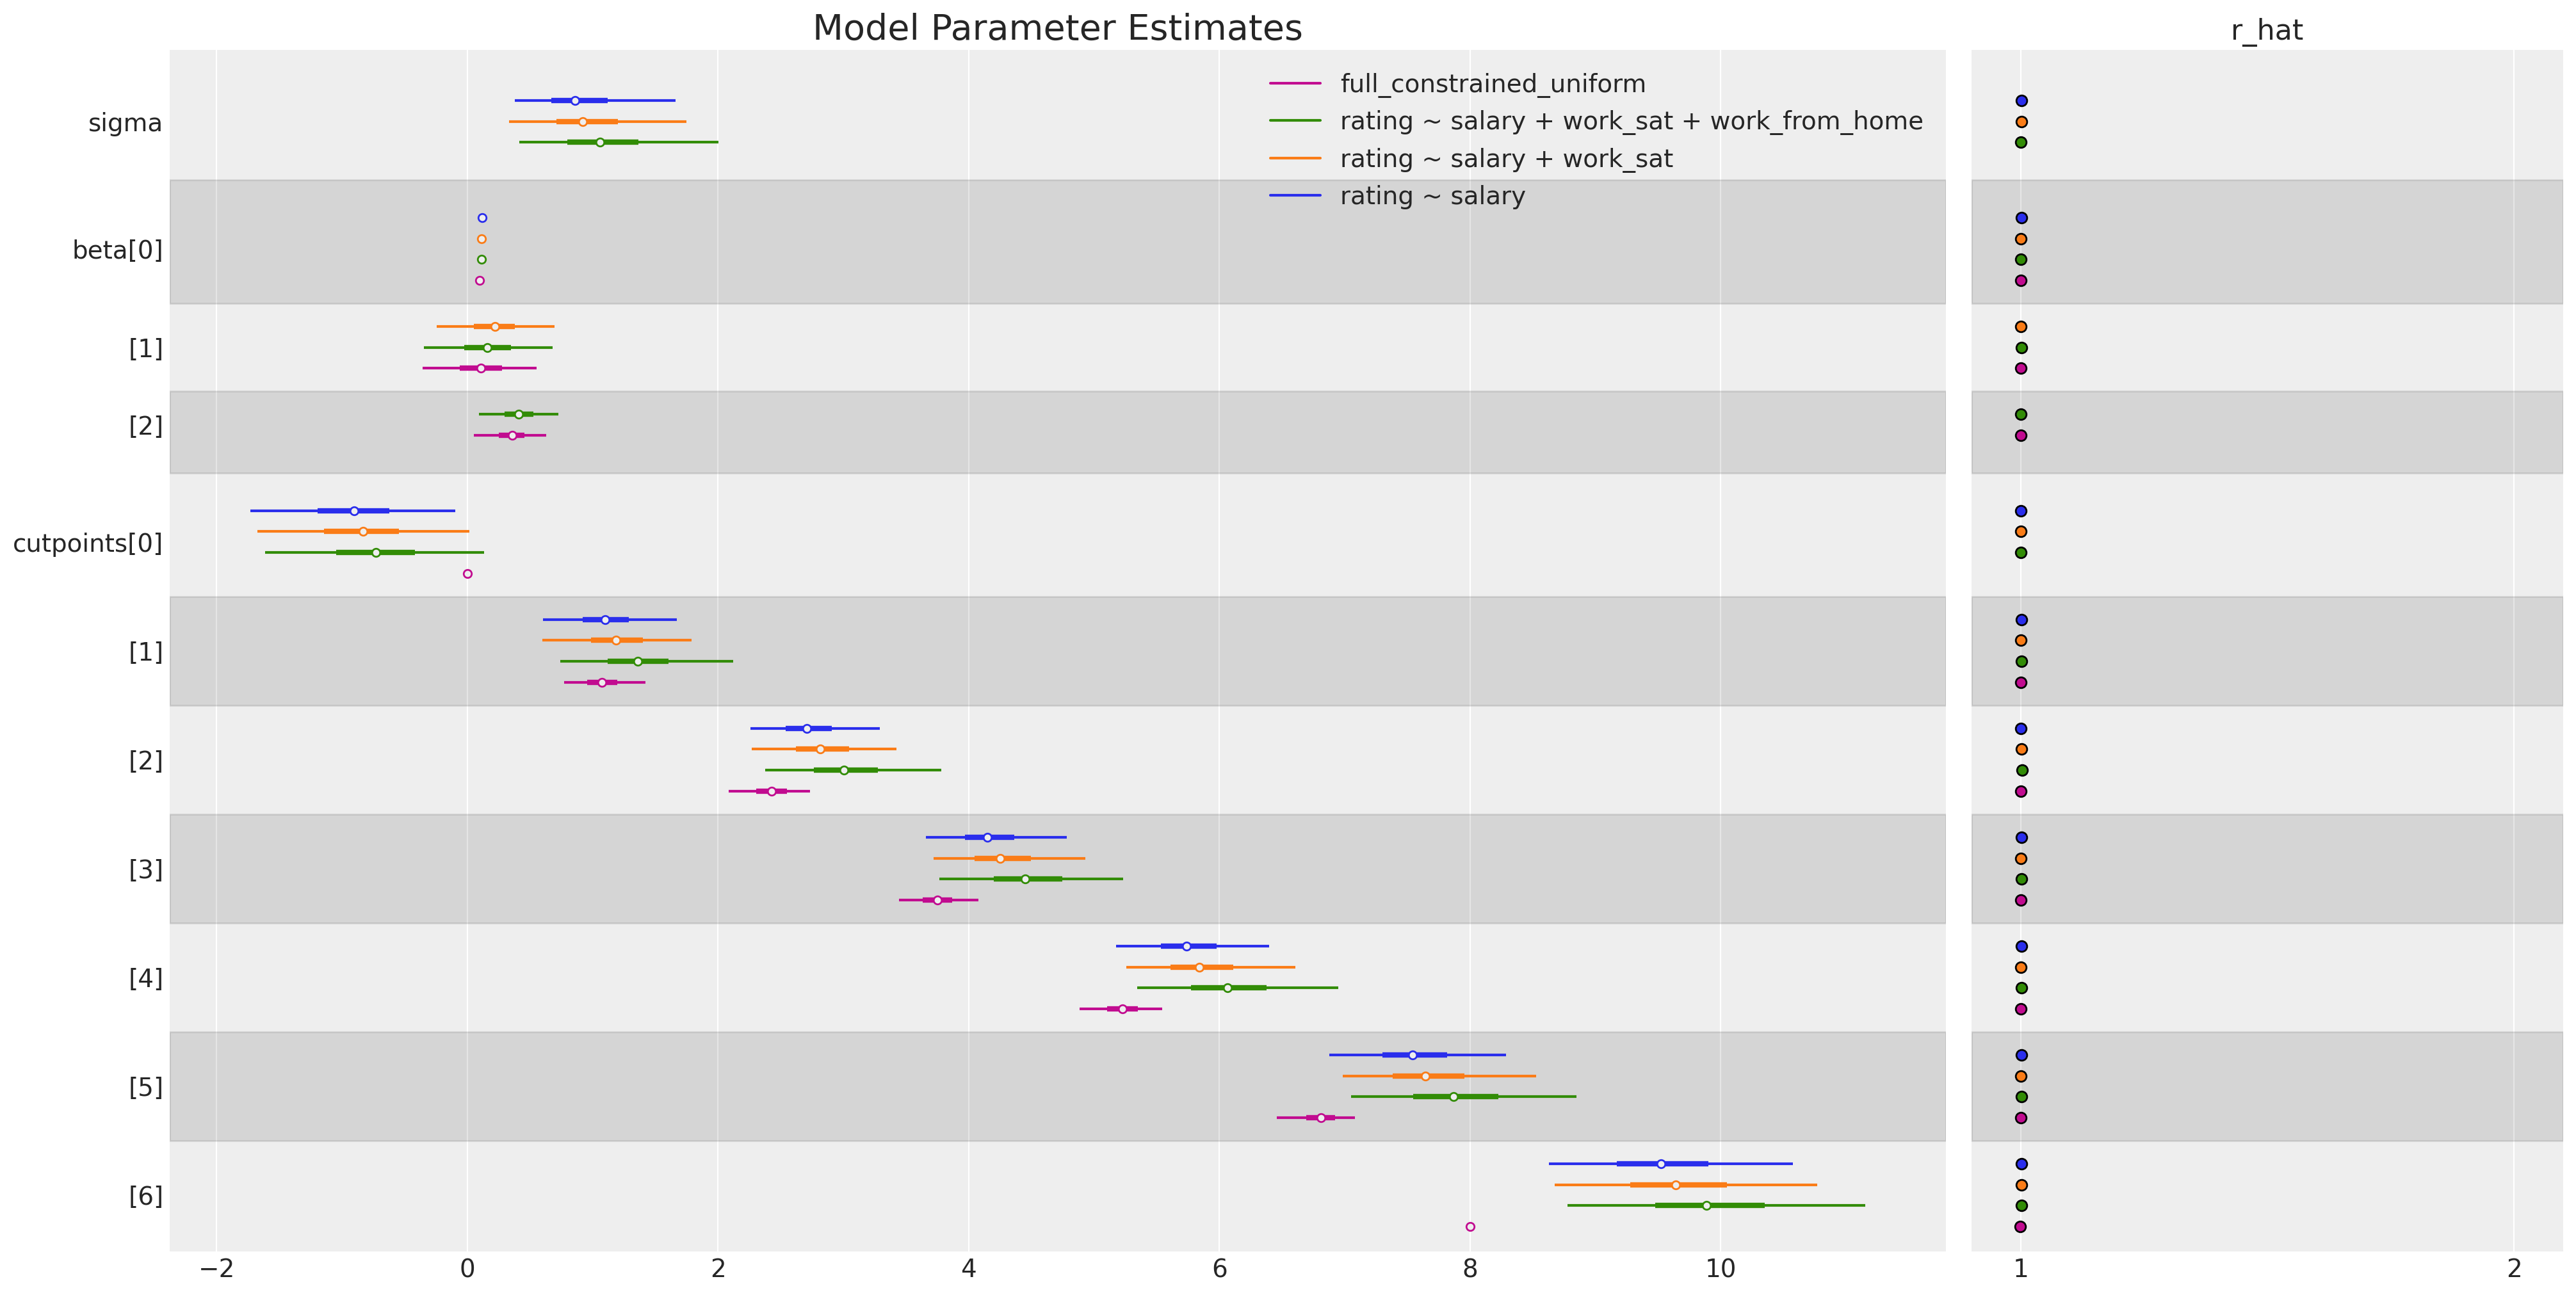

In [16]:
ax = az.plot_forest(
    [idata1, idata2, idata3, idata4],
    var_names=["sigma", "beta", "cutpoints"],
    combined=True,
    ridgeplot_overlap=4,
    figsize=(20, 10),
    r_hat=True,
    ridgeplot_alpha=0.3,
    model_names=[
        "rating ~ salary",
        "rating ~ salary + work_sat",
        "rating ~ salary + work_sat + work_from_home",
        "full_constrained_uniform",
    ],
)
ax[0].set_title("Model Parameter Estimates", fontsize=20)

In [17]:
az.summary(idata3, var_names=["cutpoints", "beta", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
cutpoints[0],-0.732,0.472,-1.612,0.136,0.010,0.008,2057.0,2048.0,1.0
cutpoints[1],1.382,0.373,0.741,2.122,0.008,0.006,2565.0,2248.0,1.0
cutpoints[2],3.037,0.382,2.375,3.784,0.009,0.006,1928.0,2155.0,1.0
cutpoints[3],4.491,0.402,3.765,5.231,0.010,0.007,1853.0,2159.0,1.0
cutpoints[4],6.095,0.439,5.347,6.948,0.011,0.008,1749.0,1819.0,1.0
cutpoints[5],7.910,0.494,7.049,8.849,0.012,0.009,1702.0,1881.0,1.0
cutpoints[6],9.930,0.637,8.776,11.152,0.016,0.011,1567.0,2339.0,1.0
beta[0],0.116,0.009,0.100,0.133,0.000,0.000,1806.0,2113.0,1.0
beta[1],0.161,0.272,-0.345,0.681,0.005,0.004,3033.0,2790.0,1.0
beta[2],0.418,0.169,0.092,0.728,0.003,0.002,3585.0,3050.0,1.0


## Compare Cutpoints: Normal V Uniform Priors

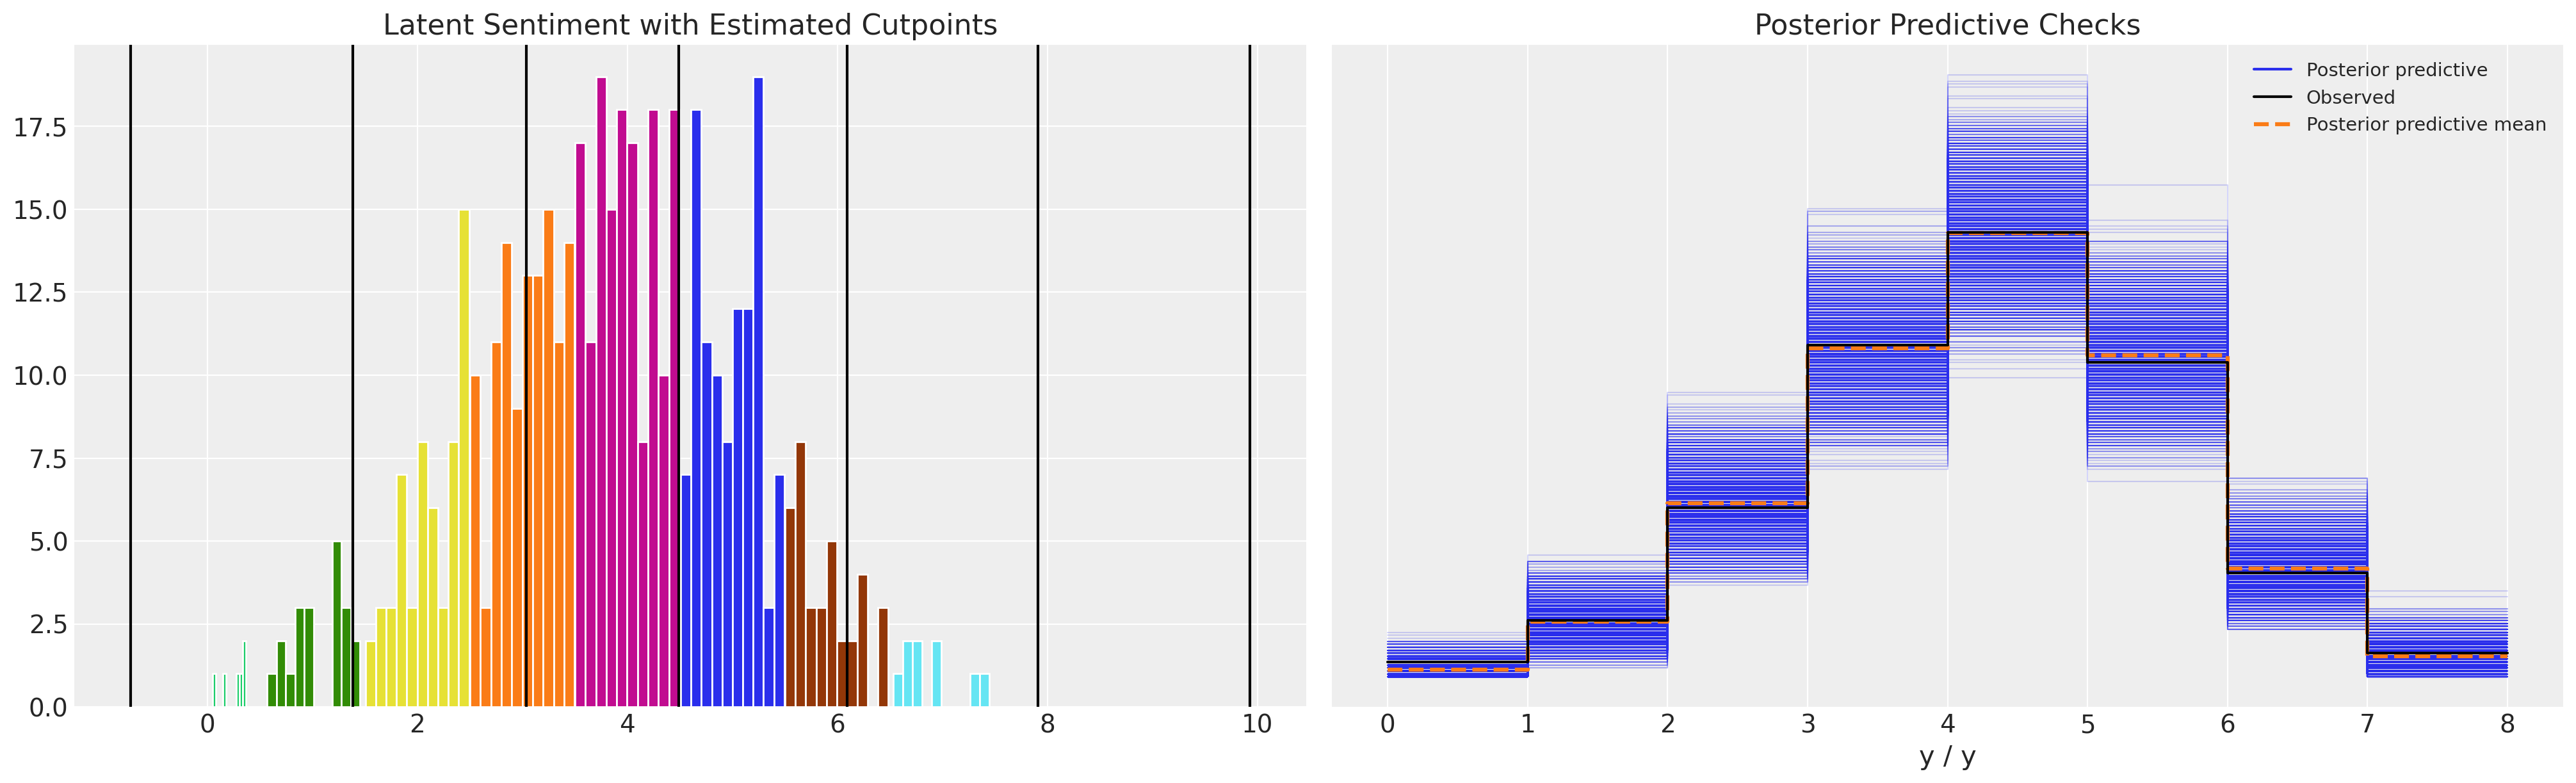

In [18]:
def plot_fit(idata):
    posterior = idata.posterior.stack(sample=("chain", "draw"))
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))
    axs = axs.flatten()
    ax = axs[0]
    for i in range(K - 1):
        ax.axvline(posterior["cutpoints"][i].mean().values, color="k")
    for r in df["explicit_rating"].unique():
        temp = df[df["explicit_rating"] == r]
        ax.hist(temp["latent_rating"], ec="white")
    ax.set_title("Latent Sentiment with Estimated Cutpoints")
    axs[1].set_title("Posterior Predictive Checks")
    az.plot_ppc(idata, ax=axs[1])
    plt.show()


plot_fit(idata3)

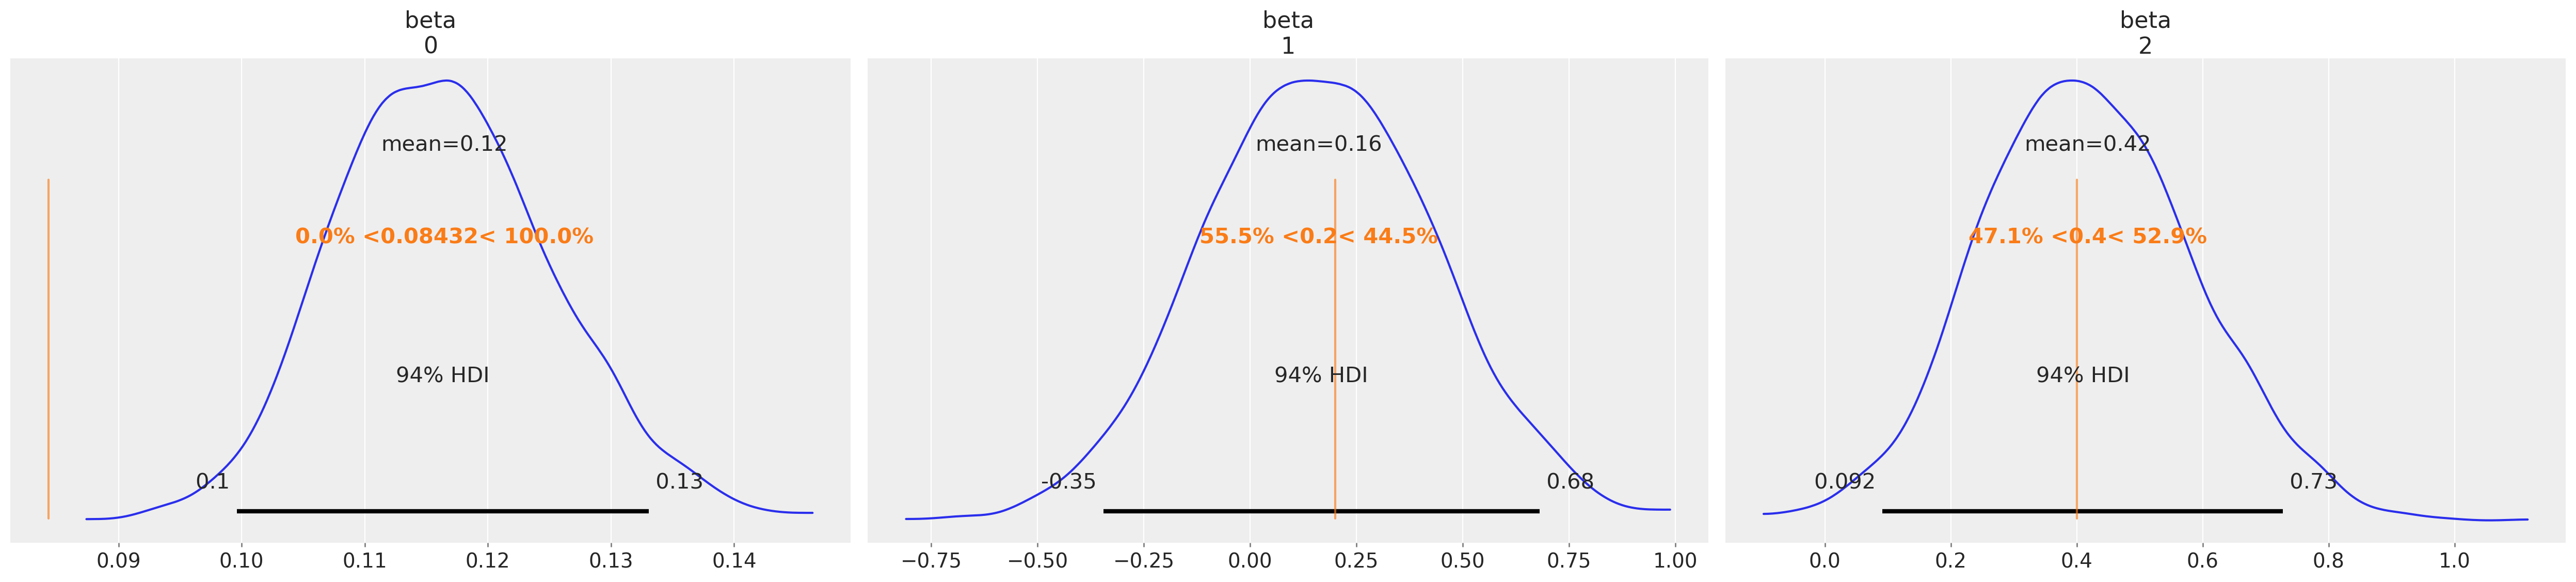

In [19]:
az.plot_posterior(idata3, var_names=["beta"], ref_val=[0.08432, 0.2, 0.4]);

While the parameter estimates seem reasonable and the posterior predictive checks seem good too, the point to see here is that the cutpoints are unconstrained by the definition of the ordinal scale. They vary below 0 in the above model.

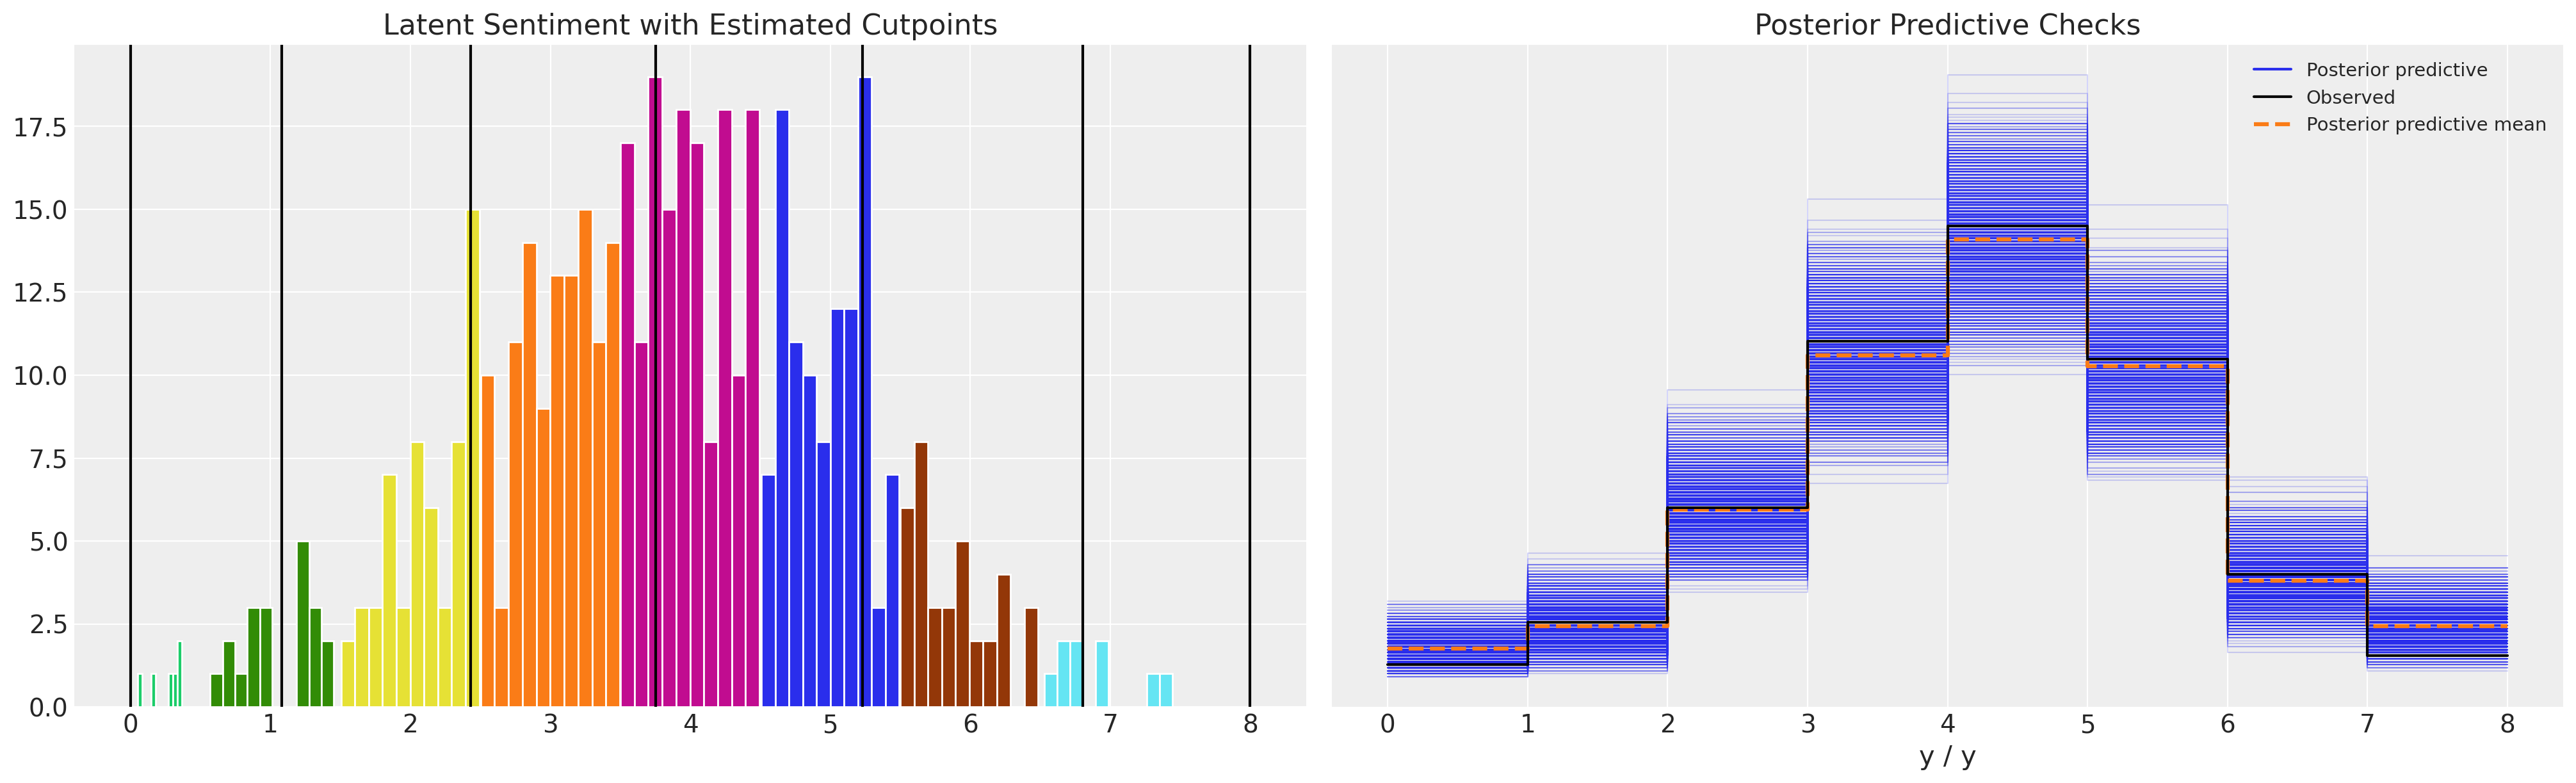

In [20]:
plot_fit(idata4)

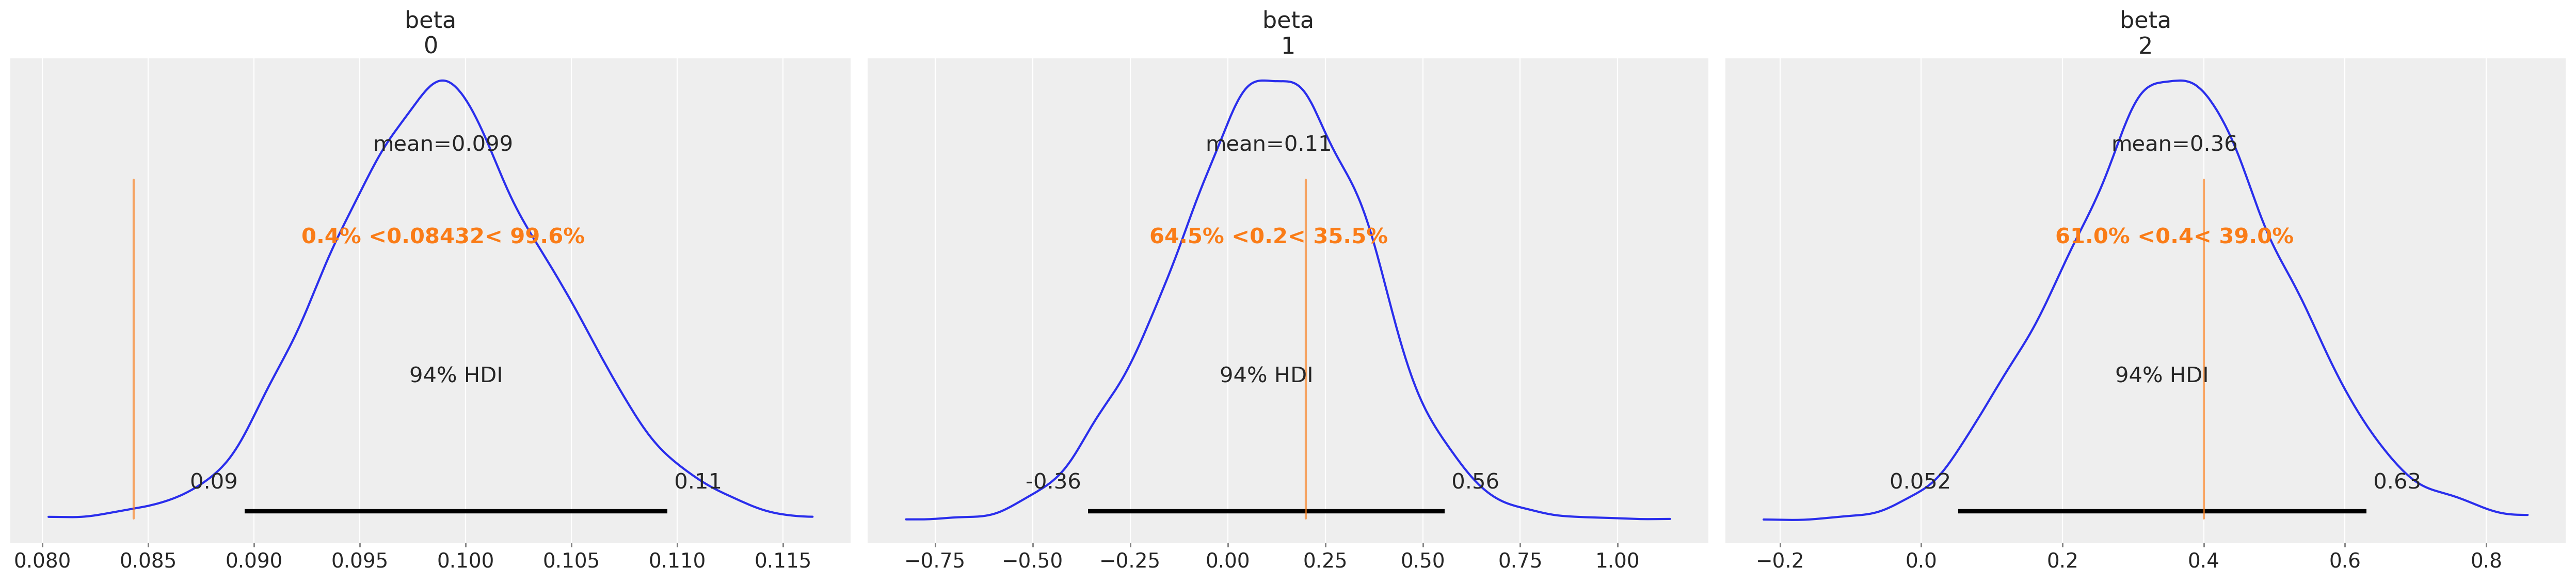

In [21]:
az.plot_posterior(idata4, var_names=["beta"], ref_val=[0.08432, 0.2, 0.4]);

Again the parameters seem reasonable, and posterior predictive checks are sound. But now, having using the constrained uniform prior over the cutpoints our estimated cutpoints respect the definition of the ordinal scale. 

## Comparison to Statsmodels

In [22]:
modf_logit = OrderedModel.from_formula(
    "explicit_rating ~ salary + work_sat + work_from_home", df, distr="logit"
)
resf_logit = modf_logit.fit(method="bfgs")
resf_logit.summary()

Optimization terminated successfully.
         Current function value: 1.517705
         Iterations: 49
         Function evaluations: 55
         Gradient evaluations: 55


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:        explicit_rating   Log-Likelihood:                -758.85
Model:                   OrderedModel   AIC:                             1538.
Method:            Maximum Likelihood   BIC:                             1580.
Date:                Mon, 20 Mar 2023                                         
Time:                        23:08:13                                         
No. Observations:                 500                                         
Df Residuals:                     490                                         
Df Model:                          10                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
salary             0.1250      0.009     13.321      0.000       0.107       0.143
work_sat           0.3803      0.286      1.328      0.184      -0.181       0.942
work_from_home     0.4933      0.171      2.880      0.004       0.158       0.829
0.0/1.0            0.3098      0.554      0.560      0.576      -0.775       1.395
1.0/2.0            0.5237      0.228      2.297      0.022       0.077       0.971
2.0/3.0            0.4672      0.126      3.704      0.000       0.220       0.714
3.0/4.0            0.3723      0.087      4.303      0.000       0.203       0.542
4.0/5.0            0.4889      0.074      6.644      0.000       0.345       0.633
5.0/6.0            0.6099      0.090      6.771      0.000       0.433       0.786
6.0/7.0            0.6224      0.172      3.619      0.000       0.285       0.960
==================================================================================
"""

## Authors
- Authored by [Nathaniel Forde](https://github.com/NathanielF) in April 2023 

## References
:::{bibliography}
:filter: docname in docnames
:::

## Watermark

In [23]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Mon Mar 20 2023

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.11.0

pytensor: 2.10.1

arviz      : 0.15.1
pytensor   : 2.10.1
pandas     : 1.5.3
numpy      : 1.24.2
matplotlib : 3.7.1
statsmodels: 0.13.5
pymc       : 5.1.1

Watermark: 2.3.1



:::{include} ../page_footer.md
:::